# RNN-LSTM-GRU on IMDb classification

+ `../RNN`里记录了PyTorch官方对NLR用RNN的十分基本的demo, 感觉很这种text classification很适合作为年轻人的第一个RNN, 以及后续的LSTM, GRU, ...作为练手
+ ~~正好我在kaggle上找到了一个扩大化的[数据集](https://www.kaggle.com/datasets/amaleshvemula7/name-and-country-of-origin-dataset), 非常不错~~
+ ~~我就给down下来在`./data`, 这里针对这个问题, 做一个从RNN到LSTM到GRU的练手!~~
+ 额, 本来准备做一个简单的name2country的分类, 结果发现kaggle那个数据集菜的一批...算了算了...还是去pytorch里找个dataset吧
+ 用IMDb dataset就!

## Structure

+ ~~这里做数据处理代码的开发, 具体训练啥的分别开一个notebook去搞~~
+ ~~数据处理开发好之后还得导出到py里去~~
+ 这里直接搞吧就...也挺好, 省事了, 不用操心预处理
+ 吸取教训, 一开始还是用官方大牌的dataset去练手!

# RNN

## issues

+ 额, 为什么我down个IDMB的dataset都能有问题的, torchtext你在干嘛啊, 为啥不直接用Dataset, 非要搞个什么datapipes...
   * nm, 是网络问题, 我开了狗洞之后就可以了, 服了...

In [1]:
import os.path

In [2]:
import numpy as np
import pandas as pd

In [3]:
import time

In [4]:
import torch
import torch.nn as nn

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torch.nn.utils.rnn import pad_sequence


In [12]:
import matplotlib.pyplot as plt

In [5]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return self.fc(hidden.squeeze(0))

def tokenize_text(text, tokenizer, vocab):
    return torch.tensor([vocab[token] for token in tokenizer(text)])

# Define the function to process the label
def process_label(label):
    return torch.tensor(float(label == 1))

def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_label, _text) in batch:
        label_list.append(process_label(_label))
        processed_text = tokenize_text(_text, tokenizer, vocab)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    return pad_sequence(text_list, padding_value=vocab['<pad>']).to(device), torch.tensor(label_list).to(device), lengths


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

train_iter, test_iter = torchtext.datasets.IMDB(root = './data')

dp_train = train_iter.set_length(len(list(train_iter)))
dp_test = test_iter.set_length(len(list(test_iter)))

vocab = build_vocab_from_iterator(map(tokenizer, map(lambda x: x[1], train_iter)), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])


INPUT_DIM = len(vocab)
EMBEDDING_DIM = 20
HIDDEN_DIM = 40
OUTPUT_DIM = 1
INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM

dp_train = dp_train.shuffle()

dlr = torch.utils.data.DataLoader(dp_train, batch_size=64, collate_fn=collate_batch)

dlr_test = torch.utils.data.DataLoader(dp_test, batch_size=64, collate_fn=collate_batch)



In [7]:
device

device(type='cuda')

In [8]:

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [9]:

model.train()

losses = []
for epoch in range(1000):
    total_loss = 0
    for text, labels, _ in dlr:
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)
        if np.isnan(loss.item()):
            print("nan loss! Stop")
            break
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss/len(dlr))
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss/len(dlr)}, @ {time.ctime()}")


Epoch: 0, Loss: 0.6519079109287018, @ Sat Sep 23 14:59:29 2023
Epoch: 10, Loss: 0.6972635004221631, @ Sat Sep 23 15:04:19 2023
Epoch: 20, Loss: 0.6960146672585431, @ Sat Sep 23 15:09:11 2023
Epoch: 30, Loss: 0.6953679050326043, @ Sat Sep 23 15:14:04 2023
Epoch: 40, Loss: 0.6950723698072117, @ Sat Sep 23 15:18:55 2023
Epoch: 50, Loss: 0.6940291202281748, @ Sat Sep 23 15:23:47 2023
Epoch: 60, Loss: 0.6943043952097978, @ Sat Sep 23 15:28:40 2023
Epoch: 70, Loss: 0.6944531350184584, @ Sat Sep 23 15:33:32 2023
Epoch: 80, Loss: 0.6941007148579258, @ Sat Sep 23 15:38:24 2023
Epoch: 90, Loss: 0.6948714413301414, @ Sat Sep 23 15:43:16 2023
Epoch: 100, Loss: 0.6934829967101211, @ Sat Sep 23 15:48:09 2023
Epoch: 110, Loss: 0.6936332778552609, @ Sat Sep 23 15:53:00 2023
Epoch: 120, Loss: 0.693587314289854, @ Sat Sep 23 15:57:51 2023
Epoch: 130, Loss: 0.6955915956241091, @ Sat Sep 23 16:02:41 2023
Epoch: 140, Loss: 0.6939773750122246, @ Sat Sep 23 16:07:33 2023
Epoch: 150, Loss: 0.6932717624222836,

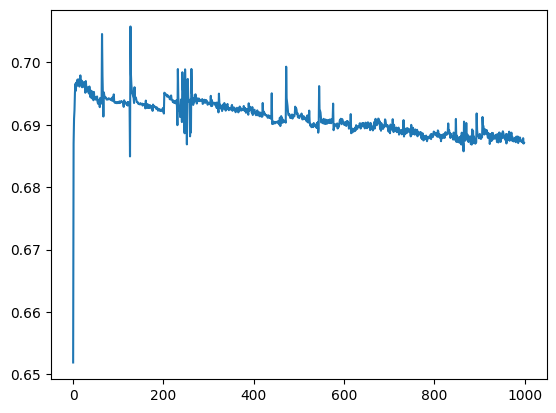

In [13]:
plt.plot(losses)

In [14]:
model.eval()

RNN(
  (embedding): Embedding(121067, 20)
  (rnn): RNN(20, 40)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [16]:
def getAcc(pred, labels):
    label_pred = (torch.sigmoid(pred) > 0.5).float()
    acc = (label_pred == labels).float().mean()
    return acc.detach().cpu()

In [17]:
accs = []
for text, labels, _ in dlr_test:
    accs.append(getAcc(model(text), labels))

In [22]:
accT = torch.tensor(accs).mean()

In [23]:
accT

tensor(0.5004)

In [89]:
acc

tensor(0.5006, device='cuda:0')